# Call center data modeling

## Loading the data

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load the data set containing durations between calls arriving at the call center.
# All values are in minutes.
waiting_times_day = np.loadtxt('call_center.csv')

In [3]:
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

Size of data set: 5891
First 3 values in data set: [5.36 2.48 8.08]
Sum of data set: 1442.145437310004


## Data pre-processing

In [4]:
# Split the data into 24 separate series, one for each hour of the day
current_time = 0
waiting_times_per_hour = [[] for _ in range(24)]  # Make 24 empty lists, one per hour
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

for hour, waiting_times_hour in enumerate(waiting_times_per_hour):
    print('%02i:00-%02i:00 - %i calls' % (hour, hour + 1, len(waiting_times_hour)))

00:00-01:00 - 7 calls
01:00-02:00 - 5 calls
02:00-03:00 - 8 calls
03:00-04:00 - 7 calls
04:00-05:00 - 21 calls
05:00-06:00 - 42 calls
06:00-07:00 - 96 calls
07:00-08:00 - 189 calls
08:00-09:00 - 274 calls
09:00-10:00 - 344 calls
10:00-11:00 - 487 calls
11:00-12:00 - 892 calls
12:00-13:00 - 869 calls
13:00-14:00 - 401 calls
14:00-15:00 - 206 calls
15:00-16:00 - 169 calls
16:00-17:00 - 261 calls
17:00-18:00 - 430 calls
18:00-19:00 - 579 calls
19:00-20:00 - 383 calls
20:00-21:00 - 136 calls
21:00-22:00 - 45 calls
22:00-23:00 - 28 calls
23:00-24:00 - 12 calls


## Computing a 95% posterior confidence interval and posterior mean

In [5]:
def get_posterior(data):
    # Use a gamma distribution with parameters (1,0.25) as prior
    prior_alpha = 1
    prior_beta = 0.25
    # Update using data and calculate posterior
    posterior_alpha = prior_alpha + len(data)
    posterior_beta = prior_beta + sum(data)
    # Create posterior distribution using those parameters
    posterior = stats.gamma(a=posterior_alpha, scale=1/posterior_beta)
    return posterior

def get_ci_and_mean(data):
    # Call function to calculate posterior
    posterior = get_posterior(data)
    # Calculate confidence interval and mean
    confidence_95 = (posterior.ppf(0.025), posterior.ppf(0.975))
    mean = posterior.mean()
    return confidence_95, mean

# Call function for data in each hour
list_of_stats = [get_ci_and_mean(each_hour) for each_hour in waiting_times_per_hour]
# Unpack
list_of_cis, list_of_means = zip(*list_of_stats)

## Plotting results

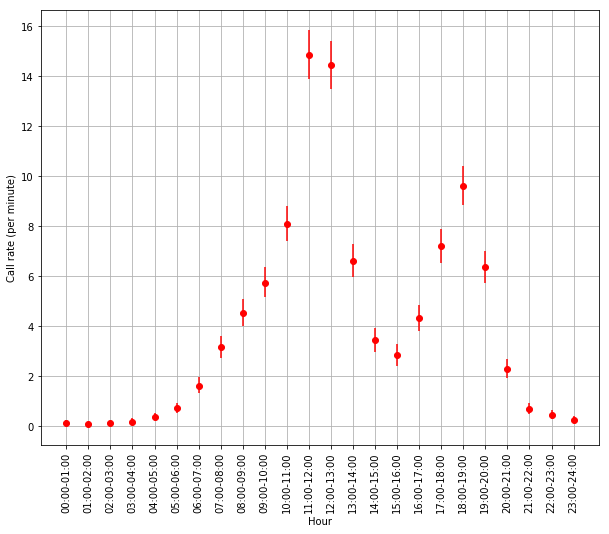

In [6]:
# Format time labels
X = ['%02i:00-%02i:00' % (hour, hour+1) for hour in range(24)]
# Calculate errorbars
list_of_ebars = np.array(list(zip(*list_of_cis)))
list_of_ebars[0,:] = list_of_means - list_of_ebars[0,:]
list_of_ebars[1,:] -= list_of_means
# Plotting
plt.figure(figsize=(10,8))
plt.errorbar(X, list_of_means, list_of_ebars, fmt='ro')
plt.xticks(rotation='vertical')
plt.xlabel("Hour")
plt.ylabel("Call rate (per minute)")
plt.grid(True)
plt.show()

# Communicating results

Generally, we see that incoming calls peak at around lunch hours centered around 12:00 and dinner hours centered around 18:30. During 11:00-13:00, you should be expecting around 15 calls per minute, and might get to as many as 16 and as few as 13. During the rest of the awake hours 7:00-21:00, you should be expecting between 2 and 11 calls per minute. During the rest of the day, we should be expecting at most 2 calls per minute. For more detailed information on each hour, you could look at the plot above. The red dot in each hour column represents the average number of calls that arrive per minute. The line represents uncertainty. We are 95% confident that the call rates lie within those regions.

In addition, you could refer to the table below for predictions on the number of calls arriving at each hour:

In [7]:
# Construct dataframe for table display
df = {"Average number of calls:": np.zeros(24, dtype=int),
     "Number of calls is most likely between:": []}
# Sampling rate parameter from posterior, then sample data from likelihood
for hour in range(24):
    posterior = get_posterior(waiting_times_per_hour[hour])
    n = 100000
    samples = stats.poisson.rvs(posterior.rvs(size=n)*60)
    df["Average number of calls:"][hour] = round(samples.mean())
    df["Number of calls is most likely between:"].append("%i and %i" %
            (np.percentile(samples,2.5), np.percentile(samples,97.5)))
# Display
df = pd.DataFrame(df, index=X)
df.index.name = "Hour"
print(df)

             Average number of calls: Number of calls is most likely between:
Hour                                                                         
00:00-01:00                         8                                2 and 17
01:00-02:00                         5                                1 and 13
02:00-03:00                         8                                2 and 16
03:00-04:00                        11                                3 and 22
04:00-05:00                        22                               11 and 37
05:00-06:00                        43                               26 and 62
06:00-07:00                        97                              71 and 126
07:00-08:00                       189                             153 and 229
08:00-09:00                       273                             228 and 319
09:00-10:00                       345                             294 and 398
10:00-11:00                       486                           

# Stretch goal

## Reparametrizing normal distribution
PDF of the normal distribution parametrized by mean and variance is expressed as

$$p^{(\mu, \sigma^2)} = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

Substituting $\sigma^2=\frac{1}{\tau}$, we can obtain the PDF parametrized by mean and precision:

$$
p^{(\mu, \tau)} = \frac{1}{\sqrt{2\pi/\tau}} e^{-\frac{\tau}{2}(x-\mu)^2}
=\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau}{2}(x-\mu)^2}
$$

## Change of variable in normal-inverse-gamma distribution 
PDF for normal-inverse-gamma distribution is

$$p_{\sigma^2}(\sigma^2) = \frac{\sqrt{\lambda}}{\sqrt{2\pi\sigma^2}} \frac{\beta^{\alpha}}{\Gamma(\alpha)} \left(\frac{1}{\sigma^2}\right)^{\alpha+1} e^{-\frac{2\beta+\lambda(x-\mu)^2}{2\sigma^2}}$$

In this task, we are changing the variable of the probability distribution rather than substituting a parameter and therefore cannot do simple subsitution. 

We know that for a PDF $p$, the value of the function $p(x)$ only gives us the probability density, whereas $p(x) dx$ gives us the actualy probability that the outcome lies at the infinitestimal region between $x$ and $x+dx$. If we want to change the variable in a distribution, we need to keep the probabilities invariant and not densities. Using mathematical notations, this must hold:

$$
\left|p_x(x) dx \right| = \left|p_y(y) dy\right|
$$

where taking the absolute value is necessary because x and y might be inversely related. Applying the above equation and substituting $\sigma^2=\frac{1}{\tau}$ and $\frac{d\sigma^2}{d\tau} = -\tau^{-2}$, we have

$$
\begin{aligned}
p_{\tau}(\tau) &= \left|\frac{d\sigma^2}{d\tau}\right| \cdot p_{\sigma^2}(\frac{1}{\tau})\\
&= \tau^{-2} \cdot \frac{\sqrt{\lambda \tau}}{\sqrt{2\pi}}  \frac{\beta^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha+1} e^{-\frac{\tau}{2}\left(2\beta+\lambda(x-\mu)^2\right)}\\
&= \frac{\beta^{\alpha} \sqrt{\lambda}}{\Gamma(\alpha)\sqrt{2\pi}} \tau^{\alpha-\frac{1}{2}} e^{-\beta\tau} e^{-\frac{\lambda\tau}{2} (x-\mu)^2}
\end{aligned}
$$

The last expression matches the PDF of normal-gamma distribution.
